<a href="https://colab.research.google.com/github/Polineska/Sentiment-reviews-CR/blob/main/RuBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn
!pip install pandas scikit-learn transformers torch
!pip install transformers scikit-learn pandas torch openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
import torch

In [3]:
file_path = "data (1).xlsx"
data = pd.concat([pd.read_excel(file_path, sheet_name=sheet) for sheet in pd.ExcelFile(file_path).sheet_names],ignore_index=True)

data = data[["разметка", "текст"]].dropna()
data["разметка"] = data["разметка"].replace({"neg": "negative"})

valid_classes = ["positive", "negative", "neutral", "skip", "speech"]
data = data[data["разметка"].isin(valid_classes)]

In [4]:
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["разметка"])
print("Классы для обучения:", label_encoder.classes_)

Классы для обучения: ['negative' 'neutral' 'positive' 'skip' 'speech']


In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["текст"].astype(str),
    data["label"],
    test_size=0.1,
    random_state=42
)

In [6]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, list(train_labels))
test_dataset = TextDataset(test_encodings, list(test_labels))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [7]:
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

print("Обучение модели...")
trainer.train()

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Обучение модели...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: polinabog475 (polinabog475-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.839500,0.713492,0.755660
2,0.522800,0.631073,0.809524
3,0.413600,0.733771,0.830601


TrainOutput(global_step=4323, training_loss=0.6303135635619525, metrics={'train_runtime': 3481.7462, 'train_samples_per_second': 9.93, 'train_steps_per_second': 1.242, 'total_flos': 9097309775692800.0, 'train_loss': 0.6303135635619525, 'epoch': 3.0})

In [8]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
report = classification_report(test_labels, preds, target_names=label_encoder.classes_, digits=2)
print("Классификационный отчет:")
print(report)

Классификационный отчет:
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73       133
     neutral       0.60      0.44      0.51       136
    positive       0.73      0.67      0.70        98
        skip       0.86      0.90      0.88       858
      speech       0.68      0.77      0.72        56

    accuracy                           0.81      1281
   macro avg       0.72      0.70      0.71      1281
weighted avg       0.80      0.81      0.80      1281



In [9]:
import os
output_dir = "./saved_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Модель и токенизатор сохранены в {output_dir}")

Модель и токенизатор сохранены в ./saved_model


In [11]:
output_dir = './saved_model'
file_path = 'Test_data.xlsx'

xls = pd.ExcelFile(file_path)
data = pd.concat([xls.parse(sheet) for sheet in xls.sheet_names], ignore_index=True)

data = data[["разметка", "текст"]].dropna()
data["разметка"] = data["разметка"].replace({"neg": "negative"})
valid_classes = ["positive", "negative", "neutral", "skip", "speech"]
data = data[data["разметка"].isin(valid_classes)]

label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["разметка"])
print("Классы для обучения:", label_encoder.classes_)


Классы для обучения: ['negative' 'neutral' 'positive' 'skip' 'speech']


In [12]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["текст"].astype(str),
    data["label"],
    test_size=0.2,
    random_state=42
)
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [13]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

In [14]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, list(train_labels))
test_dataset = TextDataset(test_encodings, list(test_labels))

In [15]:
model = BertForSequenceClassification.from_pretrained(output_dir)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [16]:
def evaluate_model(model, test_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = DataLoader(test_dataset, batch_size=16)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)

    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    return accuracy, class_report

In [17]:
accuracy, class_report = evaluate_model(model, test_dataset)
print(f'Accuracy: {accuracy * 100:.2f}%')
print("\nКлассификационный отчет:\n", class_report)

Accuracy: 90.30%

Классификационный отчет:
               precision    recall  f1-score   support

    negative       0.86      0.82      0.84       262
     neutral       0.79      0.78      0.78       221
    positive       0.90      0.80      0.85       212
        skip       0.93      0.95      0.94      1675
      speech       0.79      0.78      0.78       105

    accuracy                           0.90      2475
   macro avg       0.85      0.83      0.84      2475
weighted avg       0.90      0.90      0.90      2475



<ipython-input-18-6e145bd0c533>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=precisions, palette="viridis")


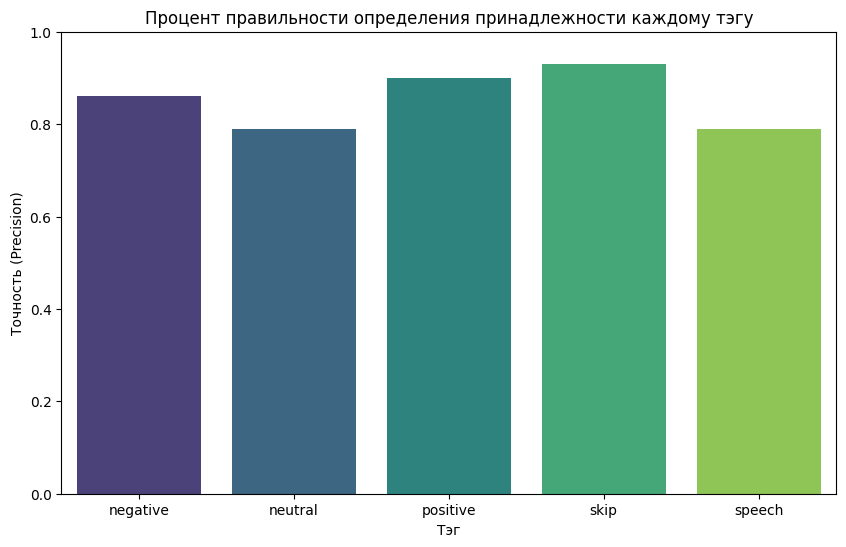

In [18]:
import torch
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

def evaluate_model(model, test_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    test_loader = DataLoader(test_dataset, batch_size=16)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)
    return accuracy, class_report
accuracy, class_report = evaluate_model(model, test_dataset)

class_names = list(class_report.keys())[:-3]
precisions = [class_report[class_name]['precision'] for class_name in class_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=precisions, palette="viridis")
plt.title("Процент правильности определения принадлежности каждому тэгу")
plt.xlabel("Тэг")
plt.ylabel("Точность (Precision)")
plt.ylim(0, 1)
plt.show()